In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

from hmmlearn.hmm import GaussianHMM

In [21]:
df = pd.read_csv('../data/time_series_15min_singleindex.csv')
df = df[['cet_cest_timestamp', 'DE_50hertz_wind_generation_actual']]
df.columns = ['Timestamp', 'Value']
df.index = pd.to_datetime(df['Timestamp'], utc=True)
df = df.drop('Timestamp', axis=1)
df = df[df.index.year >= 2007]
df = df.fillna(df.rolling(24*4, min_periods=1).median())
df

,Value
Timestamp,
2007-01-01 00:00:00+00:00,5148.000
2007-01-01 00:15:00+00:00,5284.000
2007-01-01 00:30:00+00:00,5423.000
2007-01-01 00:45:00+00:00,5608.000
2007-01-01 01:00:00+00:00,5661.000
...,...
2019-04-30 22:45:00+00:00,2556.719
2019-04-30 23:00:00+00:00,2500.904
2019-04-30 23:15:00+00:00,2503.766


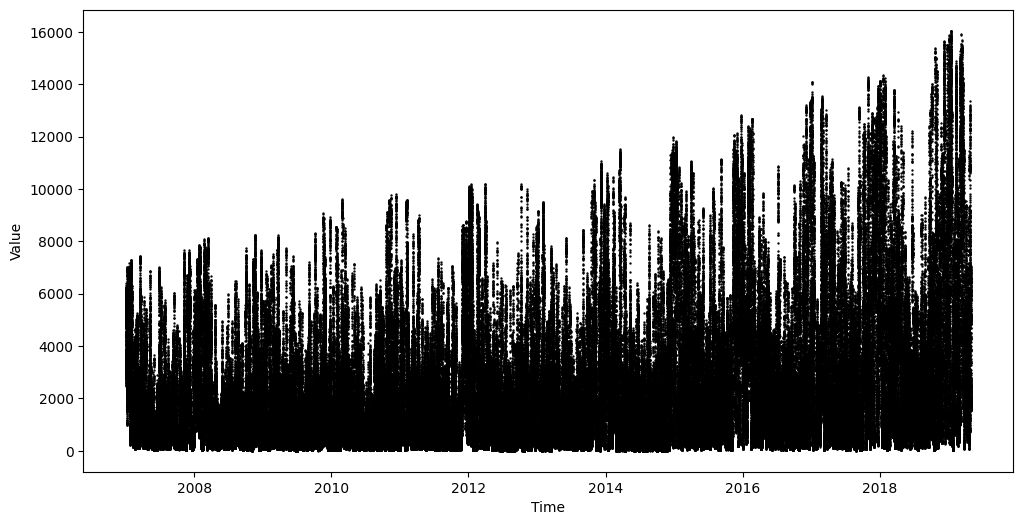

In [22]:
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Value'], s=0.5, color='black')
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

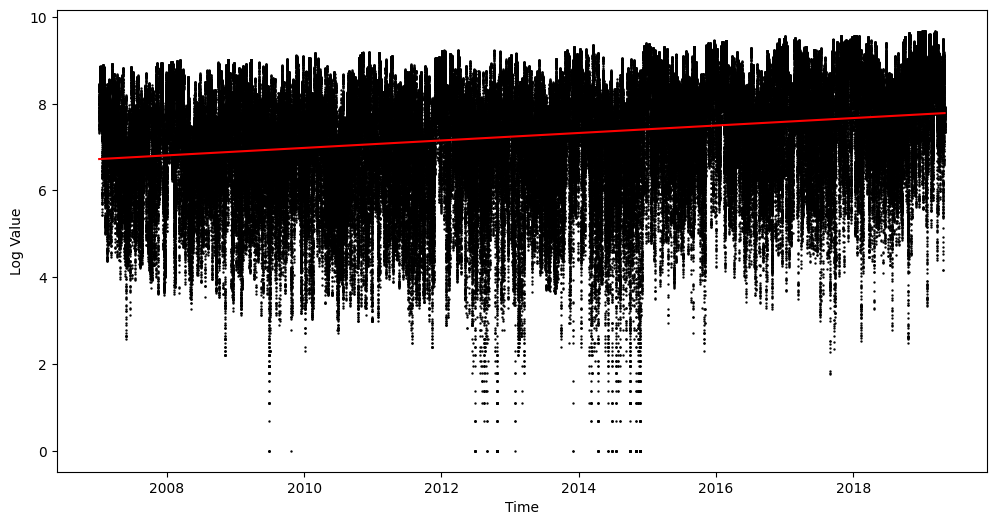

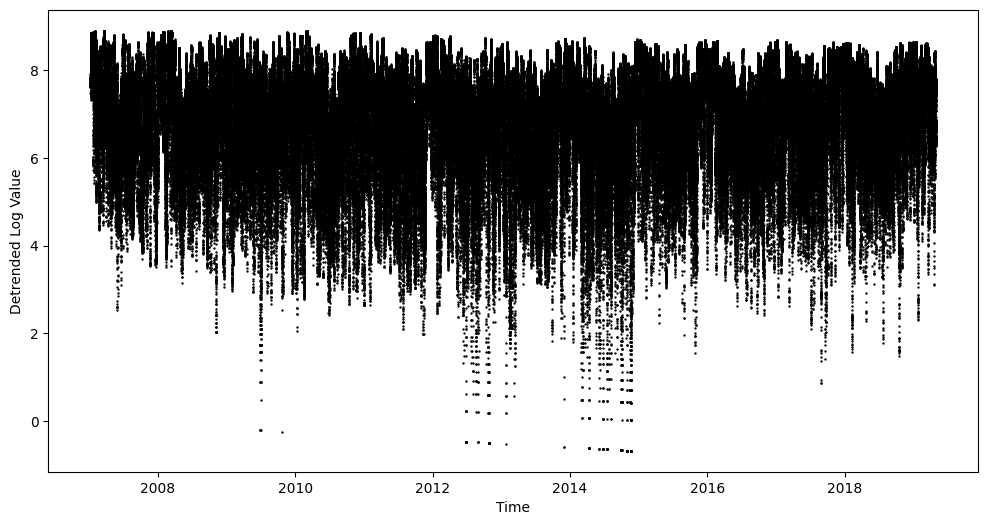

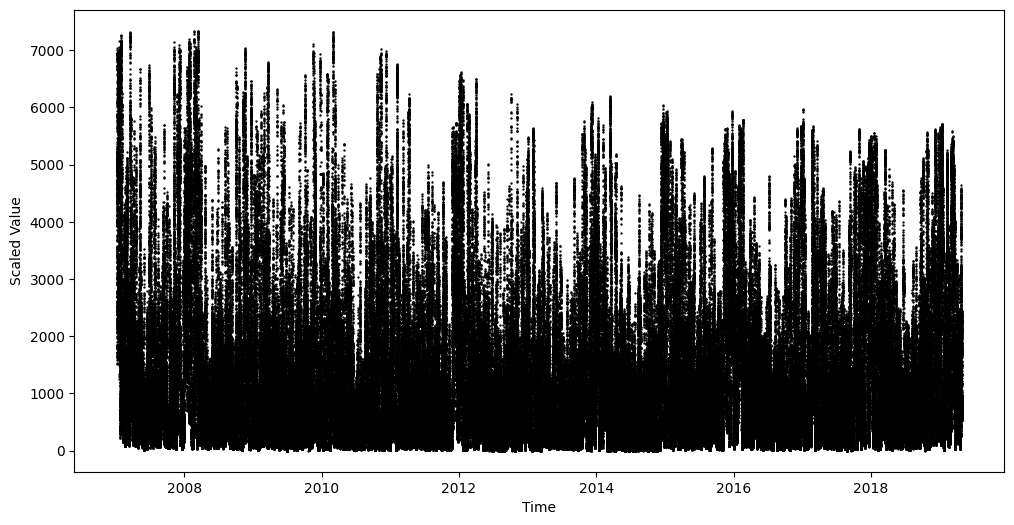

In [105]:
df['Log Value'] = np.log(df['Value'] + 1)

tmp_values = df['Log Value'].to_numpy()
t = np.arange(len(tmp_values))
m, c = np.polyfit(t, tmp_values, 1)

plt.figure(figsize=(12, 6))
plt.scatter(df.index, tmp_values, s=0.5, color='black')
plt.plot(df.index, m*t + c, color='red')
plt.xlabel("Time")
plt.ylabel("Log Value")
plt.show()

tmp_values = tmp_values - m*t
plt.figure(figsize=(12, 6))
plt.scatter(df.index, tmp_values, s=0.5, color='black')
plt.xlabel("Time")
plt.ylabel("Detrended Log Value")
plt.show()

df['Scaled Value'] = np.exp(tmp_values) - 1
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Scaled Value'], s=0.5, color='black')
plt.xlabel("Time")
plt.ylabel("Scaled Value")
plt.show()

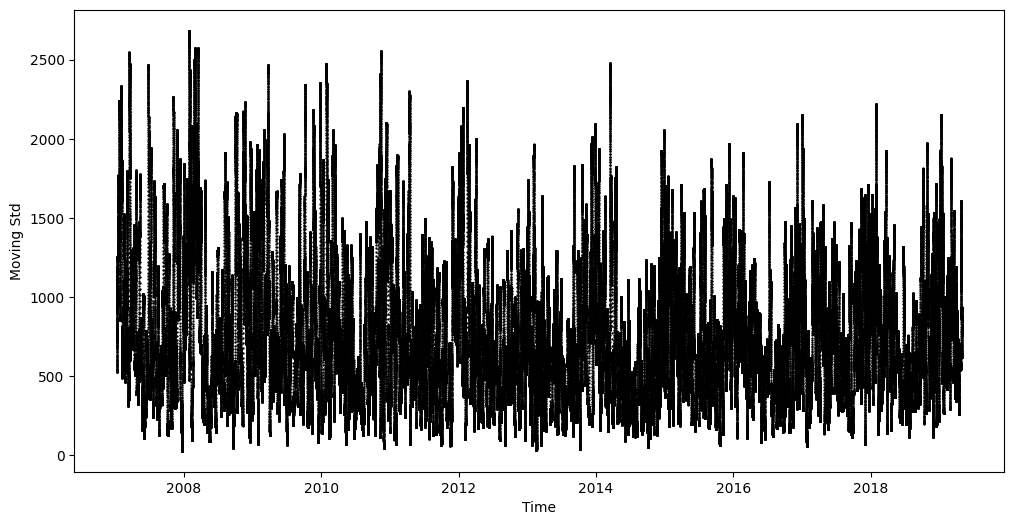

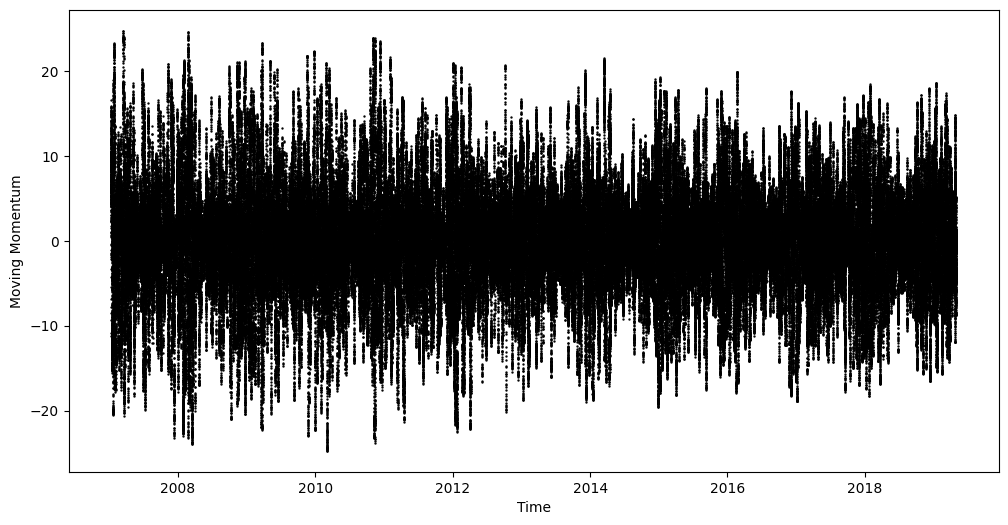

In [106]:
window = 24*4*3
df['Moving Std'] = df['Scaled Value'].rolling(window=window).std()
df['Moving Momentum'] = df['Scaled Value'].rolling(window=window).apply(lambda x: np.mean(np.diff(x)))
df.dropna(inplace=True)

plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Moving Std'], s=0.5, color='black')
plt.xlabel("Time")
plt.ylabel("Moving Std")
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Moving Momentum'], s=0.5, color='black')
plt.xlabel("Time")
plt.ylabel("Moving Momentum")
plt.show()

In [107]:
X = df[['Moving Std', 'Moving Momentum']].values
X = (X - X.mean(axis=0)) / X.std(axis=0)
model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
model.fit(X)

df["Regime"] = model.predict(X)
df['Regime'] = df['Regime'].shift(-window // 2)
df['Regime'] = df['Regime'].ffill()

In [138]:
with open('../models/hmm.pkl', 'wb') as f:
    pickle.dump(model, f)

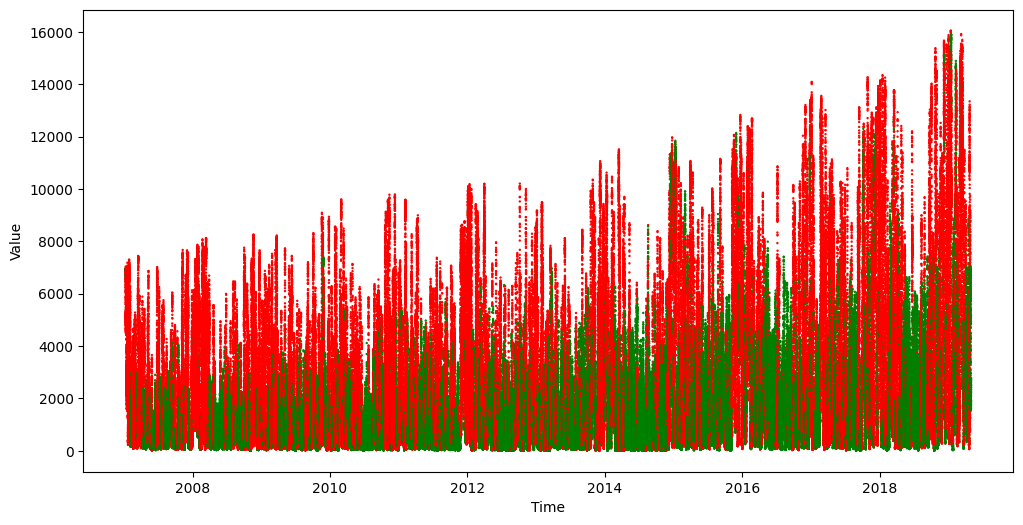

In [108]:
color_mapping = {0: 'r', 1: 'g'}

df['Color'] = df['Regime'].map(color_mapping)

plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['Value'], c=df['Color'], s=0.5)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

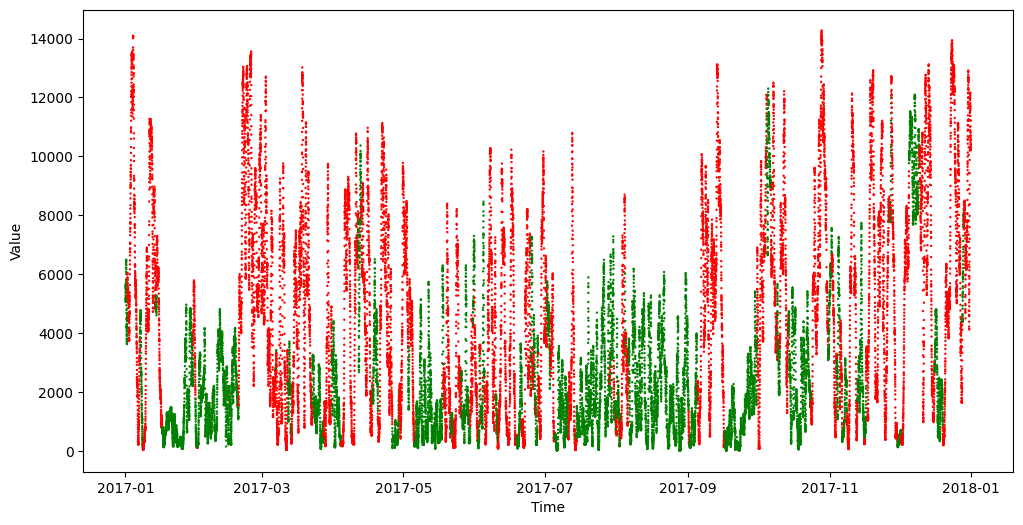

In [109]:
df_2017 = df[df.index.year == 2017]

plt.figure(figsize=(12, 6))
plt.scatter(df_2017.index, df_2017['Value'], c=df_2017['Color'], s=0.5)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [110]:
df['Day'] = df.index.date
daily_df = pd.DataFrame(df.groupby('Day')['Regime'].value_counts(normalize=True).unstack())
daily_df.fillna(0, inplace=True)
daily_df.index = pd.to_datetime(daily_df.index)

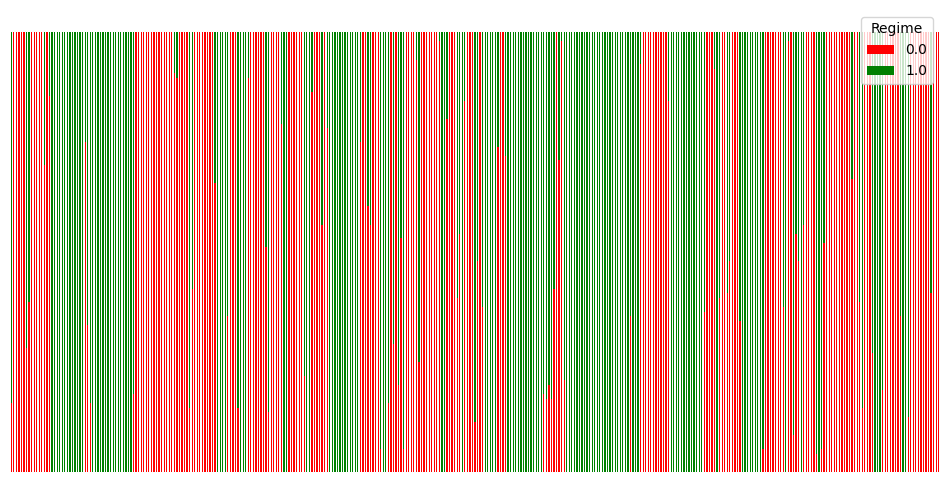

In [111]:
fig, ax = plt.subplots(figsize=(12, 6))
daily_df[daily_df.index.year == 2017].plot(kind='bar', stacked=True, ax=ax, color=['r', 'g'])
ax.axis('off');

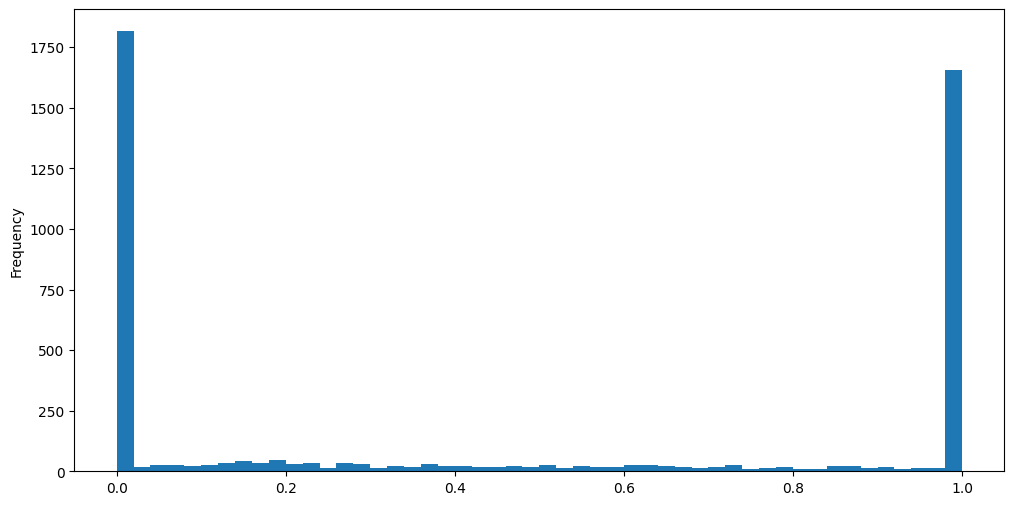

In [112]:
daily_df[0].plot(kind='hist', figsize=(12, 6), bins=50);

In [113]:
daily_df['Regime'] = (daily_df[0] > daily_df[1]).astype(int)
daily_df['Regime'].value_counts()

Regime
0    2433
1    2062
Name: count, dtype: int64

In [115]:
daily_df = daily_df[['Regime']].join(df.groupby('Day')['Value'].apply(lambda df: df.reset_index(drop=True)).unstack())
daily_df.dropna(inplace=True)
daily_df

,Regime,0,1,2,3,4,5,6,7,8,...,86,87,88,89,90,91,92,93,94,95
Day,,,,,,,,,,,,,,,,,,,,,
2007-01-10,1,5059.000,5062.000,5060.000,5084.000,5233.000,5308.000,5206.000,5237.000,5225.000,...,6571.000,6708.000,6672.000,6748.000,6733.000,6942.000,7037.000,7008.000,6853.000,6870.000
2007-01-11,1,6822.000,6854.000,6934.000,6889.000,6662.000,6468.000,6340.000,6238.000,6122.000,...,6590.000,6453.000,6543.000,6606.000,6742.000,6622.000,6639.000,6725.000,6645.000,6652.000
2007-01-12,1,6745.000,6913.000,6953.000,6886.000,6931.000,6909.000,6880.000,6960.000,6947.000,...,6933.000,6967.000,6994.000,6938.000,6950.000,6897.000,6898.000,6865.000,6840.000,6816.000
2007-01-13,1,6808.000,6765.000,6770.000,6761.000,6723.000,6676.000,6628.000,6668.000,6746.000,...,3774.000,3893.000,3941.000,3947.000,3807.000,3752.000,3948.000,4272.000,4433.000,4428.000
2007-01-14,1,4421.000,4587.000,4773.000,4734.000,4822.000,4877.000,4842.000,4996.000,5178.000,...,4857.000,4663.000,4459.000,4236.000,4028.000,3801.000,3693.000,3755.000,3844.000,3845.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-26,1,7193.116,7045.434,6914.275,6707.261,6521.999,6378.698,6236.533,5920.335,5702.734,...,8054.274,7896.057,7724.400,7560.943,7527.533,7577.145,7514.184,7412.612,7304.748,7020.723
2019-04-27,1,6852.745,6417.257,6124.811,6226.590,6065.058,5702.410,5372.918,5056.581,4940.717,...,1958.611,1964.356,1903.834,1910.871,1998.677,2091.857,2151.803,2156.254,2152.725,2144.450
2019-04-28,0,2215.081,2344.015,2479.051,2623.138,2709.700,2757.070,2733.366,2733.966,2688.361,...,2783.315,2881.254,2981.488,3082.094,3279.011,3416.517,3358.530,3360.266,3504.175,3666.050


In [120]:
regimes = daily_df['Regime'].values
transition_matrix = np.zeros((2, 2))
for i in range(1, len(regimes)):
    transition_matrix[regimes[i-1], regimes[i]] += 1
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
transition_matrix

array([[0.83799342, 0.16200658],
       [0.19165454, 0.80834546]])

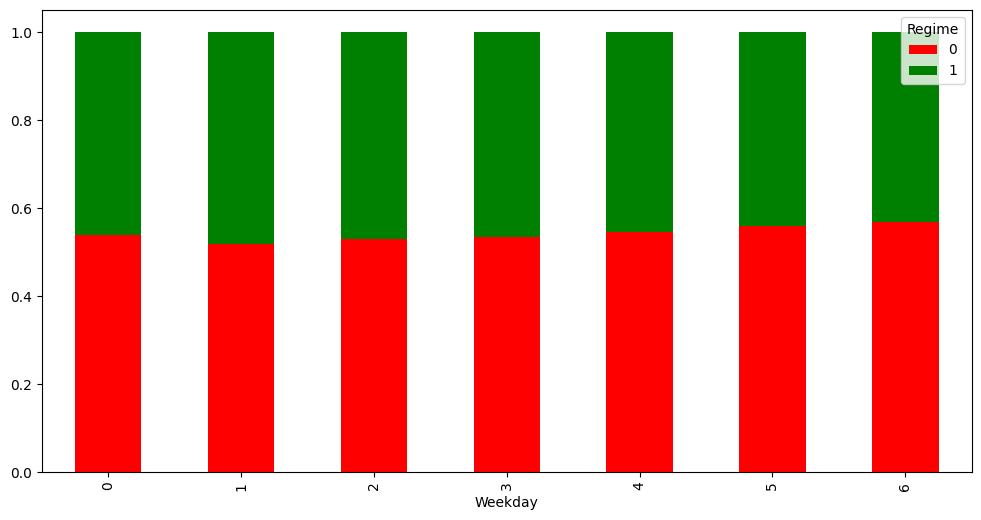

In [125]:
daily_df['Weekday'] = daily_df.index.day_of_week

daily_df.groupby('Weekday')['Regime'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(12, 6), color=['r', 'g']);

In [134]:
np.save('../data/X.npy', daily_df[list(range(96))].to_numpy())
np.save('../data/y.npy', daily_df['Regime'].to_numpy())